<a href="https://colab.research.google.com/github/stephanie0620/113_1/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 使用 yfinance 抓取股價資料

In [1]:
import yfinance as yf
import pandas as pd

def get_stock_data(stock_id, start_date, end_date):
    '''
    使用 yfinance 抓取股價資料

    參數：
    - stock_id (str): 股票代號
    - start_date (str): 開始日期 (YYYY-MM-DD)
    - end_date (str): 結束日期 (YYYY-MM-DD)

    返回：
    - df (DataFrame): 包含股價資料的 DataFrame
    '''
    df = yf.download(stock_id, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.columns = ['開盤價', '最高價', '最低價', '收盤價', '成交量']
    return df


In [2]:
# 抓取台積電 2024 年的股價
df_org = get_stock_data('2330.TW', '2020-01-01', '2023-01-01')
df_org.head()

[*********************100%***********************]  1 of 1 completed


,開盤價,最高價,最低價,收盤價,成交量
Date,,,,,
2020-01-02 00:00:00+00:00,332.5,339.0,332.5,339.0,31754120
2020-01-03 00:00:00+00:00,344.0,345.0,335.5,339.5,41811268
2020-01-06 00:00:00+00:00,333.0,334.5,332.0,332.0,45343057
2020-01-07 00:00:00+00:00,332.5,333.0,326.5,329.5,50879181
2020-01-08 00:00:00+00:00,325.0,333.0,325.0,329.5,37567748


In [3]:
df = df_org.copy()
df.columns

Index(['開盤價', '最高價', '最低價', '收盤價', '成交量'], dtype='object')

## 作業1：使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

In [7]:
def prepare_data(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

def build_lstm_model(window_size):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_and_predict(stock_id, start_date, end_date, window_size):
    # 抓取資料並選擇收盤價
    df = get_stock_data(stock_id, start_date, end_date)
    close_prices = df['收盤價'].values.reshape(-1, 1)

    # 資料縮放
    scaler = MinMaxScaler()
    close_prices_scaled = scaler.fit_transform(close_prices)

    # 分割訓練集與測試集
    train_size = int(len(close_prices_scaled) * 0.8)
    train_data, test_data = close_prices_scaled[:train_size], close_prices_scaled[train_size:]

    # 準備訓練和測試資料
    X_train, y_train = prepare_data(train_data, window_size)
    X_test, y_test = prepare_data(test_data, window_size)

    # LSTM 模型訓練
    model = build_lstm_model(window_size)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    # 預測
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # 還原縮放
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # 計算 RMSE
    train_rmse = sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = sqrt(mean_squared_error(y_test, test_predictions))
    print(f"訓練 RMSE: {train_rmse:.2f}")
    print(f"測試 RMSE: {test_rmse:.2f}")

    # 可視化
    train_dates = df.index[:len(y_train) + window_size]
    test_dates = df.index[len(y_train) + 2 * window_size:]

    plt.figure(figsize=(14, 7))
    plt.plot(train_dates, close_prices[:len(y_train) + window_size], label='Train Actual', color='blue')
    plt.plot(test_dates, close_prices[len(y_train) + 2 * window_size:], label='Test Actual', color='black')
    plt.plot(train_dates[window_size:], train_predictions, label='Train Prediction', color='cyan', linestyle='--')
    plt.plot(test_dates, test_predictions, label='Test Prediction', color='red', linestyle='--')

    plt.title(f'Stock Price Prediction with LSTM - Window Size: {window_size}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2369
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 16/50
18/18 ━━━━━━━━━━━━

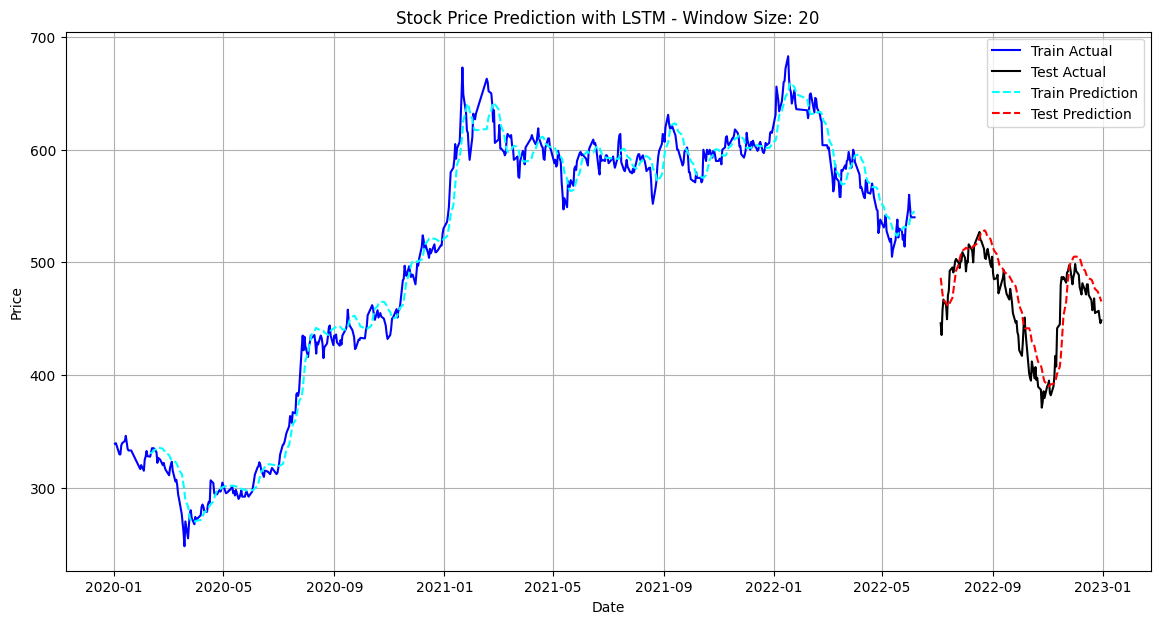

In [8]:
# 使用自訂窗口大小進行預測
train_and_predict('2330.TW', '2020-01-01', '2023-01-01', window_size=20)

## 作業2：使用 TensorFlow 實作 CNN 捕捉 K 線趨勢，並預測股價漲跌

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

In [24]:
def prepare_data_for_transformer(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])  # 預測下一天的收盤價
    return np.array(X), np.array(y)

def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1, epsilon=1e-6):
    '''
    定義單一 Transformer 編碼器塊。

    參數:
    - inputs: 輸入的張量。
    - head_size: 每個注意力頭的維度。
    - num_heads: 注意力頭的數量。
    - ff_dim: 前饋神經網路的隱藏層維度。
    - dropout_rate: Dropout 比率。
    - epsilon: 層正規化的微小數值，避免除以零。

    回傳:
    - 編碼器塊的輸出。
    '''
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout_rate
    )(x, x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Add()([x, inputs])

    x = layers.LayerNormalization(epsilon=epsilon)(x)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.Add()([x, inputs])
    return x

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=64, num_blocks=2, mlp_units=[64], dropout_rate=0.1):
    '''
    建立 Transformer 模型，包含多個編碼器塊及最終的 MLP 輸出層。

    參數:
    - input_shape: 輸入資料的形狀。
    - head_size: 每個注意力頭的維度大小。
    - num_heads: 注意力頭的數量。
    - ff_dim: 前饋神經網路的隱藏層維度。
    - num_blocks: Transformer 編碼器塊的數量。
    - mlp_units: MLP 層的神經元數。
    - dropout_rate: Dropout 比率。

    回傳:
    - Transformer 模型。
    '''
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        x = transformer_encoder_block(x, head_size, num_heads, ff_dim, dropout_rate)

    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [25]:
window_size = 20  # 設定窗口大小
# 抓取資料並選擇收盤價
df = get_stock_data('2330.TW', '2020-01-01', '2023-01-01')
close_prices = df['收盤價'].values.reshape(-1, 1)

# 資料縮放
scaler = MinMaxScaler()
close_prices_scaled = scaler.fit_transform(close_prices)

# 分割訓練集與測試集
train_size = int(len(close_prices_scaled) * 0.8)
train_data, test_data = close_prices_scaled[:train_size], close_prices_scaled[train_size:]

# 準備訓練和測試資料
X_train, y_train = prepare_data(train_data, window_size)
X_test, y_test = prepare_data(test_data, window_size)


[*********************100%***********************]  1 of 1 completed


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 20, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_26    │ (None, 20, 1)          │              2 │ input_layer_12[0][0]   │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_13   │ (None, 20, 1)          │          3,585 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_48 (Dropout)      │ (None, 20, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 20, 1)          │              0 │ dropout_48[0][0],      │
│                           │                        │                │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_27    │ (None, 20, 1)          │              2 │ add_18[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 20, 64)         │            128 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_49 (Dropout)      │ (None, 20, 64)         │              0 │ conv1d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 20, 1)          │             65 │ dropout_49[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 20, 1)          │              0 │ conv1d_19[0][0],       │
│                           │                        │                │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_28    │ (None, 20, 1)          │              2 │ add_19[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_14   │ (None, 20, 1)          │          3,585 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_51 (Dropout)      │ (None, 20, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 20, 1)          │              0 │ dropout_51[0][0],      │
│                           │                        │                │ add_19[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_29    │ (None, 20, 1)          │              2 │ add_20[0][0]           │
│ (LayerNormalization) 

 Total params: 11,731 (45.82 KB)

 Trainable params: 11,731 (45.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 703ms/step - loss: 0.2799 - val_loss: 0.2629
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1333 - val_loss: 0.0968
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0482 - val_loss: 0.0217
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - val_loss: 0.0060
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232 - val_loss: 0.0064
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0190 - val_loss: 0.0088
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0164 - val_loss: 0.0082
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160 - val_loss: 0.0069
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - val_loss: 0.0064
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - val_loss: 0.0055
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val

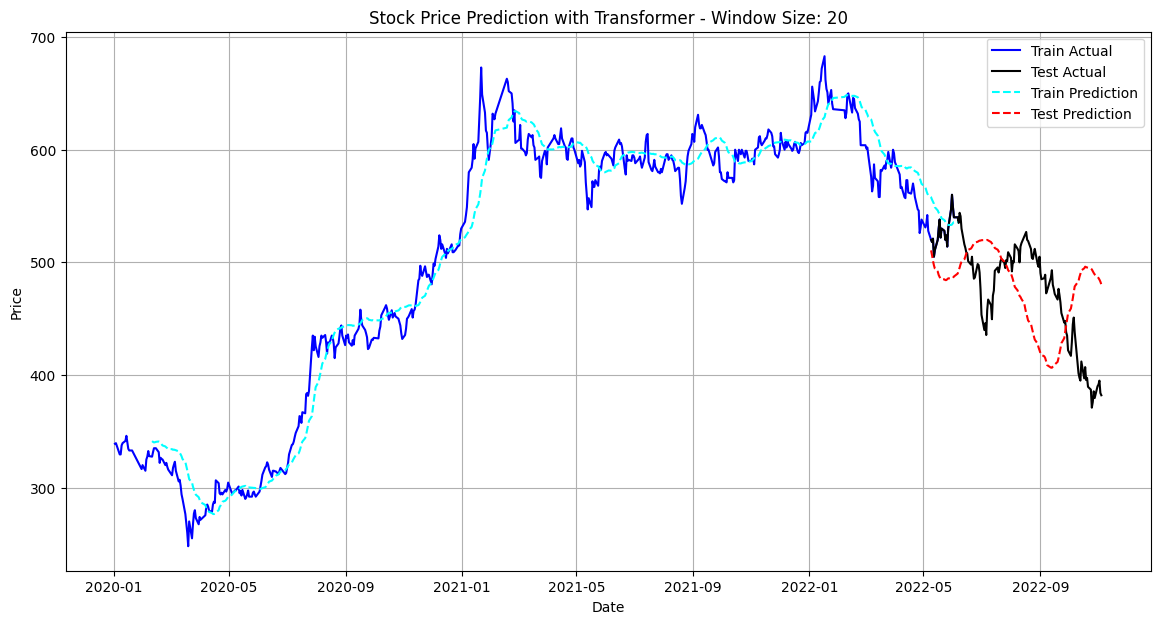

In [26]:
# 建立並編譯 Transformer 模型
transformer_model = build_transformer_model(
    input_shape=(window_size, 1),
    head_size=128,
    num_heads=4,
    ff_dim=64,
    num_blocks=3,
    mlp_units=[128],
    dropout_rate=0.1
)
transformer_model.compile(optimizer="adam", loss="mean_squared_error")
transformer_model.summary()

# 訓練模型
history = transformer_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# 預測與計算 RMSE
train_predictions = transformer_model.predict(X_train)
test_predictions = transformer_model.predict(X_test)

# 還原縮放
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

train_rmse = sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = sqrt(mean_squared_error(y_test, test_predictions))
print(f"訓練 RMSE: {train_rmse:.2f}")
print(f"測試 RMSE: {test_rmse:.2f}")

# 可視化
plt.figure(figsize=(14, 7))
train_dates = df.index[:len(y_train) + window_size]
test_dates = df.index[len(y_train):len(y_train) + len(y_test)]

plt.plot(train_dates, close_prices[:len(y_train) + window_size], label='Train Actual', color='blue')
plt.plot(test_dates, close_prices[len(y_train):len(y_train) + len(y_test)], label='Test Actual', color='black')
plt.plot(train_dates[window_size:], train_predictions, label='Train Prediction', color='cyan', linestyle='--')
plt.plot(test_dates, test_predictions, label='Test Prediction', color='red', linestyle='--')

plt.title(f'Stock Price Prediction with Transformer - Window Size: {window_size}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()